# ECS 171 Assignment 3

## Zhen Zhang (last four digit of ID: 5403)

## Nov 22, 2015

First of all, I shall say that before doing the main job in python, I use R to process the data. The script is listed below, with doing these jobs one by one:

```R
# read the data, and use regular expression to extract some identifiers
gene <- scan("ecs171.dataset.txt", what = '')
pattern <- grep("T[0-9]{3}", gene)
gene_index_start <- c(1, pattern)
gene_index_end <- c(pattern - 1, length(gene))
row_num <- length(gene_index_start)
col_num <- gene_index_end[1] - gene_index_start[1] + 1

# generate the raw data
gene_data_raw <- Map(function(i, j) gene[i:j], gene_index_start, gene_index_end)

colname <- gene_data_raw[[1]]

# if the data is shorter than the required length, add 0 at last
invisible(lapply(1:row_num, function(i) {
  if (length(gene_data_raw[[i]]) != col_num) gene_data_raw[[i]] <<- c(gene_data_raw[[i]], 0)
}))

# combine them into a dataframe
gene_data <- data.frame(do.call('rbind', gene_data_raw), stringsAsFactors = FALSE)

# drop the first row, which is the name
gene_data <- gene_data[-1, ]

# add column name
colnames(gene_data) <- colname

# drop the last column
gene_data <- gene_data[, -length(gene_data)]

# generate the combination of Medium and Stress data, which will be used in Question 5.
Medium_Stress <- unlist(Map(paste, gene_data$Medium, gene_data$Stress, sep = '.'))
gene_data[, 1] <- Medium_Stress
names(gene_data)[1] <- 'Medium_Stress'
gene_data$Medium_Stress <- as.numeric(as.factor(gene_data$Medium_Stress))

# transform relevant data to double type
invisible(lapply(2:5, function(i) {
  gene_data[[i]] <<- as.numeric(as.factor(gene_data[[i]]))
}))

# generate the final csv file
write.csv(gene_data, "~/Desktop/gene_data.csv", row.names = F)
```

Now let's begin this homework, and all the following codes are written in python.

In [1]:
# import the needed modules
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read into the data
gene = pd.read_csv("/Users/Elliot/Desktop/gene_data.csv", header = 0)
gene.data = gene.iloc[:, 6:]

I need to split the data, and following python's convention, I will give the splitted data a property. data, indicating the X.

## Question 1

In this question, I will use lasso to select the features. So lasso is a regularized technique to select features that is most relevant to the response variable. The formula is:

$$MIN\sum^{n}_{i=1}(Y_i-\sum^{p}_{j=1}X_{ij}\beta{j})^{2} + \lambda\sum^{p}_{j=1}|\beta_{j}|$$

The main idea under lasso is to put a penalty of coefficients on the size of their absolute values. It will control how much penalty the model is putting by the value of $\lambda$. When the value of $\lambda$ is large, much penalty will be put,and vice versa. Since it is a L1 norm, unlike ridge regression, it can set some of the coefficients to zero.which is what we use as a method to select features.

In [3]:
# import the needed modules used in this question
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.cross_validation import KFold

Generate the cross validation folds:

In [4]:
# cross-validation preparation
kf = KFold(gene.data.shape[0], n_folds=10)

Fit the model

In [5]:
# fit
lasso_model = LassoCV(cv=10, copy_X=True, normalize=True)
lasso_fit = lasso_model.fit(gene.data, gene.GrowthRate)

Let's look at a plot to see the general tendency of the result

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

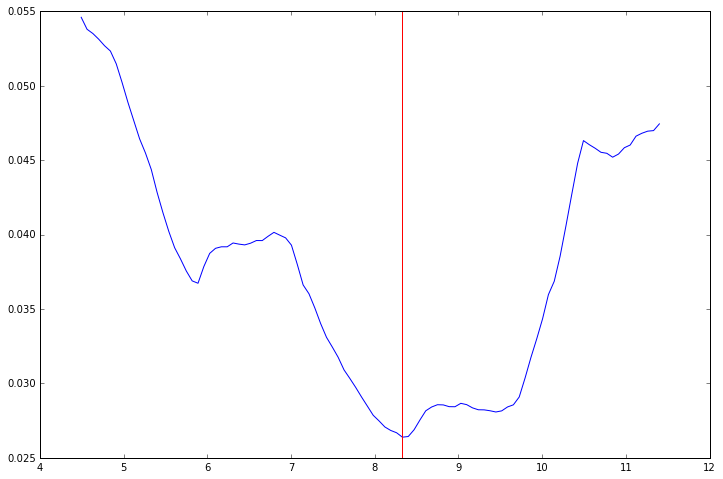

In [7]:
# Note here I made a negative log transformation to express the plot easier to see and interpret
plt.plot(-np.log(lasso_fit.alphas_), lasso_fit.mse_path_.mean(axis=1))
plt.axvline(-np.log(lasso_fit.alpha_), color='red')

From this plot, with the increase of $-log(\lambda)$ (or the decrease of $\lambda$ in $log$ scale), we can have a global optimal value lambda at:

In [8]:
print('The optimal optimal constrained parameter value is: ', lasso_fit.alpha_)

The optimal optimal constrained parameter value is:  0.000241053628825


Now let's see which coefficient is not equal to zero:

In [9]:
lasso_coefs_index = np.where(lasso_fit.coef_ != 0)
lasso_coefs_name = gene.data.columns[lasso_coefs_index].tolist()
print('The features that have non-zero coefficients are:') 
print(lasso_coefs_name)

The features that have non-zero coefficients are:
['b2353', 'b1890', 'b4131', 'b1452', 'b2505', 'b1262', 'b1463', 'b3688', 'b1673', 'b0326', 'b0440', 'b3566', 'b0621', 'b0316', 'b3170', 'b2316', 'b0303', 'b4440', 'b0724', 'b3325', 'b2059', 'b3707', 'b1044', 'b1041', 'b4450', 'b4452', 'b3829', 'b3890', 'b3637', 'b2684', 'b1926', 'b1924', 'b3693', 'b2118', 'b1148', 'b0814', 'b0565', 'b4426', 'b4251', 'b4202', 'b3525', 'b1719', 'b2587', 'b3650', 'b3990', 'b1168', 'b1160', 'b1587', 'b3332', 'b1968', 'b2909', 'b2278', 'b3876', 'b2702', 'b3441', 'b3261', 'b2643', 'b1497', 'b1729', 'b1724', 'b0741', 'b2034', 'b2036', 'b4316', 'b2905', 'b3390', 'b3665', 'b3931', 'b1237', 'b1948', 'b2528', 'b4189', 'b2741', 'b1138', 'b1398', 'b3636', 'b4299', 'b1504', 'b3640', 'b3339', 'b0016', 'b0673', 'b1546', 'b3980', 'b3276', 'b0665', 'b4165', 'b0265', 'b0668', 'b1994', 'b4512', 'b0256', 'b3968', 'b3970', 'b0540']


## Question 2

Here I will talk about my bootstrap algorithm.

**Algorithm**:

First of all, I will do the bootstrap `bs_num` times. In each loop, I select the number of samples equal to `n_samples` (the number of the original sample), and based on these selecte indices (`bs_index`) and the lasso regularized features (`lasso_coefs_index`) from the previous question, I can construct the bootstrap sample (`X_bs`). Then use lasso method to predict the output of the whole original data, then I can get the prediction (`lasso_bs_pred`). Over all loops, I can get a matrix of dimension `n_samples` * `bs_num`.

Now, I can first sort all the results each row (each sample), then select the one ranks 2.5% and 97.5% in each sample, which will be the bootstrap lower value and upper value for the 95% confidence interval.

**Assumption**:

Each sample is a valid representation of the population. Each sample is identical and independent distribution (i.i.d).

In [10]:
# bs is short for bootstrap
bs_num = 100
n_samples = gene.GrowthRate.shape[0]
gene_bs_pred = np.empty((n_samples, bs_num))
gene_features_lasso_data = gene.data[gene.data.columns[lasso_coefs_index]]

for i in range(bs_num):
    bs_index = np.random.choice(n_samples, n_samples, replace=True)
    X_bs = gene_features_lasso_data.iloc[bs_index, :]
    y_bs = gene.GrowthRate[bs_index]
    lasso_bs_pred = lasso_model.fit(X_bs, y_bs).predict(gene_features_lasso_data)
    gene_bs_pred[:, i] = lasso_bs_pred
    
gene_bs_pred_sort = np.sort(gene_bs_pred)
gene_bs_pred_result = gene_bs_pred_sort[:, [3, 97]]

print("The bootstrap 95% confidence intervals are: \n", gene_bs_pred_result)

The bootstrap 95% confidence intervals are: 
 [[ 0.60548026  0.63797747]
 [ 0.61925186  0.65298495]
 [ 0.61165469  0.64344452]
 [ 0.7152757   0.77525297]
 [ 0.66755813  0.70332481]
 [ 0.68712515  0.72694862]
 [ 0.42719536  0.47896809]
 [ 0.46359042  0.49623934]
 [ 0.47451343  0.50180409]
 [ 0.46849348  0.50292567]
 [ 0.47367457  0.50528952]
 [ 0.46875049  0.50542232]
 [ 0.41919144  0.48787493]
 [ 0.41919144  0.48787493]
 [ 0.43144947  0.50016883]
 [ 0.45984226  0.50336291]
 [ 0.414723    0.48852146]
 [ 0.44997921  0.51563823]
 [ 0.48715964  0.5458552 ]
 [ 0.4788136   0.52711435]
 [ 0.48469016  0.75718428]
 [ 0.35729005  0.82807089]
 [ 0.47042573  0.53732136]
 [ 0.33380396  0.62005511]
 [ 0.37099821  0.41202309]
 [ 0.37361807  0.40943951]
 [ 0.37633612  0.42612651]
 [ 0.35312944  0.43353269]
 [ 0.41307454  0.4494977 ]
 [ 0.38510264  0.46660825]
 [ 0.44948596  0.47352213]
 [ 0.45936549  0.48811595]
 [ 0.46103251  0.49603738]
 [ 0.46605836  0.49985815]
 [ 0.47892548  0.50670439]
 [ 0.4682

## Question 3

First I need to get the mean value of all genes:

In [11]:
gene_features_lasso_data_mean = gene_features_lasso_data.apply(np.mean, axis = 0)

Use the lasso method to predict the growth rate for the mean gene:

In [12]:
gene_features_lasso_data_mean_predict_value = lasso_fit.predict(gene_features_lasso_data_mean.reshape(1, 95))

Print the result out:

In [13]:
print('The predicted growth rate for a bacterium whose genes are expressed exactly at the mean expression value is:') 
print(gene_features_lasso_data_mean_predict_value)

The predicted growth rate for a bacterium whose genes are expressed exactly at the mean expression value is:
[ 0.40000763]


## Question 4

First I need to talk about what I am doing afterwards, since all question 4 to question 6 are all using the same functions to accomplish the task.

The first step is to import the libraries related to this part. It includes SVM, AUC, AUPRC, Cross-Validation and so on.

The second step is to define several functions which will be used afterwards. They are:

`feature_selection`: It will select the feature. Unlike the linear lasso method used in question 1, now I use a lasso method based on SVM of linear kernel. Since they are all L1 norm, they all have the ability of feature selection.

`svm_cv_score`: This function can calculate the svm score, which will be rendered to calculate the AUC and AUPRC. It accepts the data (X), target (y), and the train-test split index, and give a result of svm score.

`to_binary`: This function translates y to binary values. For example, if y has 6 classes, then translated binary y will be a 6 dimension vector, such as (0, 0, 1, 0, 0, 0).

`compute_roc`: This function calculates the FPR (False Positive Rate), TPR (True Positive Rate) and ROC Curve values. It accepts the y value and y score of SVM classification, then calculate the results. *Note here to generate a overall performance for all the classifiers, I create a micro-average curve, and plot it individually.*

`compute_pr`: This function follows the same logic as function `compute_roc`, but is calculating Recall, Precision and AUPRC Curve values.

The third step is to combine them together and plot the ROC and AUPRC curve, and this is what the function `svm_cv_roc` is doing. It accepts data (X) and target (y) as input, first it will select the feature based on L1 norm, and make the y value to binaries. Then generate the 10-fold cross-validation train-validation split, and initialize the y score matrix. After that, the y score is calculated, and use it to calculate AUC and AUPRC. Then plot them.

The fourth step is to see the plots. In the plots, I have list all the classification curves with respect to different classes and a micro-average curve for an overall performace evaluation. I also give the area value under each curve to facilitate comparison.

There are also some comments below. So if you still have some question, please see these comments.

In [14]:
# import svm library and other required functions
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.svm import SVC

In [15]:
def feature_selection(X, y):
    # This function is the feature selection using the method of L1, which is equivalent to lasso,
    # but is done inside LinearSVC.

    # set L1 penalty and select
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    # get reduced X
    X_new = model.transform(X)
    # get the number of feature selected
    n_feature = X_new.shape[1]

    return X_new, n_feature


def svm_cv_score(X, y, svc, train, test):
    # This function does the cross validation for each train and test combination in svm

    # get the train and test data based on the index
    X_train, X_test = X[train, :], X[test, :]
    y_train, y_test = y[train], y[test]
    # fit the data, get svm score to plot roc
    y_score = svc.fit(X_train, y_train).decision_function(X_test)

    return y_score


def to_binary(y):
    # This function converts a categorical vector into a binary format

    n_classes = np.max(y)
    y = label_binarize(y, classes=range(n_classes))

    return y


def compute_roc(y, y_score, n_classes):
    # This function accepts y value and the corresponding lasso score, then calculate the
    # fpr, tpr, AUC.

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return fpr, tpr, roc_auc


def compute_pr(y, y_score, n_classes):
    # This function accepts y value and the corresponding lasso score, then calculate the 
    # precision, recall, AUPRC
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y[:, i], y_score[:, i])
        
    # Compute micro-average PR cirve and AUPRC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y, y_score, average="micro")
    
    return precision, recall, average_precision

In [16]:
def svm_cv_roc(X, y):
    # This function is the main function that connects different jobs of doing svm cross validation.

    # Preparation
    n_sample = X.shape[0]
    n_classes = np.max(y)

    # Select which feature should be included in the model
    X, n_feature = feature_selection(X, y)
    
    print("The number of features selected for this variable is ", n_feature, '\n')

    # Make the output Binary
    y = to_binary(y)

    # split the data into cross-validation sets
    kf = KFold(X.shape[0], n_folds=10, shuffle=True)
    svc = OneVsRestClassifier(SVC(kernel='linear', probability=True))
    y_score = np.empty((n_sample, n_classes))
    
    # Do cross-validation
    for _, (train, test) in enumerate(kf):
        y_score_temp = svm_cv_score(X, y, svc, train, test)
        y_score[test] = y_score_temp

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = compute_roc(y, y_score, n_classes)
    
    # Compute Precision-Recall and plot curve
    precision, recall, average_precision = compute_pr(y, y_score, n_classes)
    
    # Next part are all plot functions

    # Plot micro ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
                                               ''.format(roc_auc["micro"]), linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The overall ROC curve Performance')
    plt.legend(loc="lower right")
    plt.show()

    # Plot FPR-TPR curve for each class
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC curve for each class')
    plt.legend(loc="lower right")
    plt.show()

    # Plot micro PR curve
    plt.clf()
    plt.plot(recall["micro"], precision["micro"],
             label='micro-average Precision-recall curve (area = {0:0.2f})'
                   ''.format(average_precision["micro"]))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot Precision-Recall curve for each class
    for i in range(n_classes):
        plt.plot(recall[i], precision[i],
                 label='Precision-recall curve of class {0} (area = {1:0.2f})'
                       ''.format(i, average_precision[i]))
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(loc="lower right")
    plt.show()

    
    return

Let's see each classifier related to each variable one by one.

The order of the four plots: overall ROC curve, each classifier ROC curve, overall PR curve, each classifier PR curve.

**Strain**:

The number of features selected for this variable is  18 



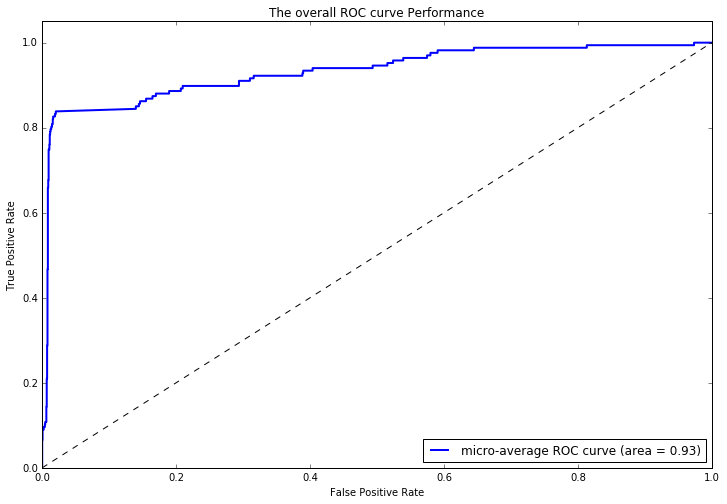

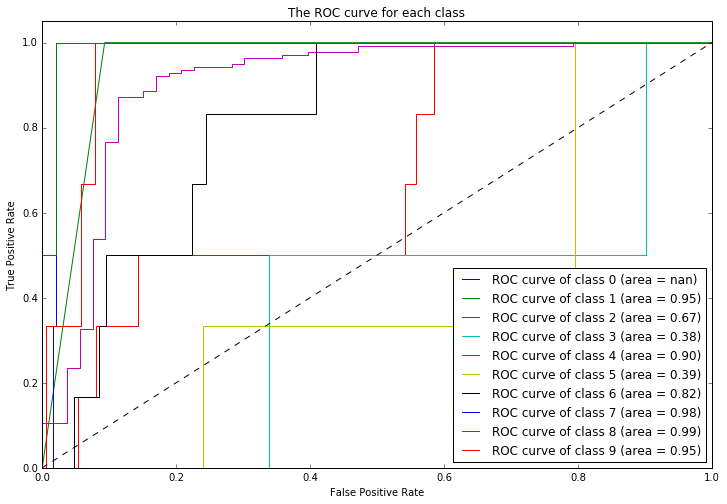

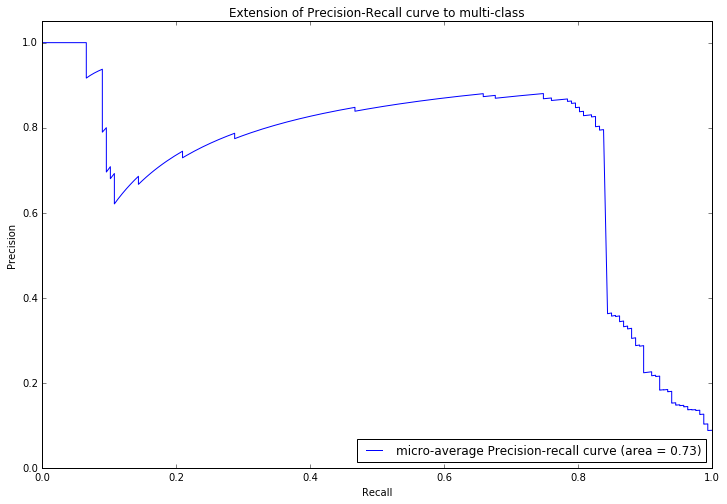

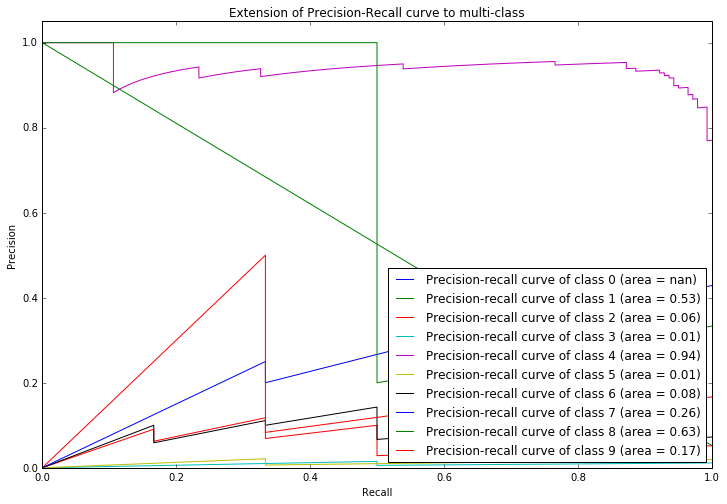

In [17]:
svm_cv_roc(gene.data, gene.Strain)

**Medium**:

The number of features selected for this variable is  29 



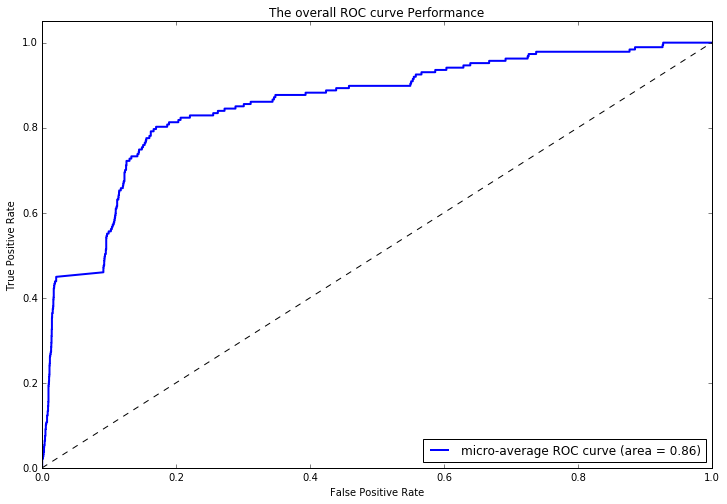

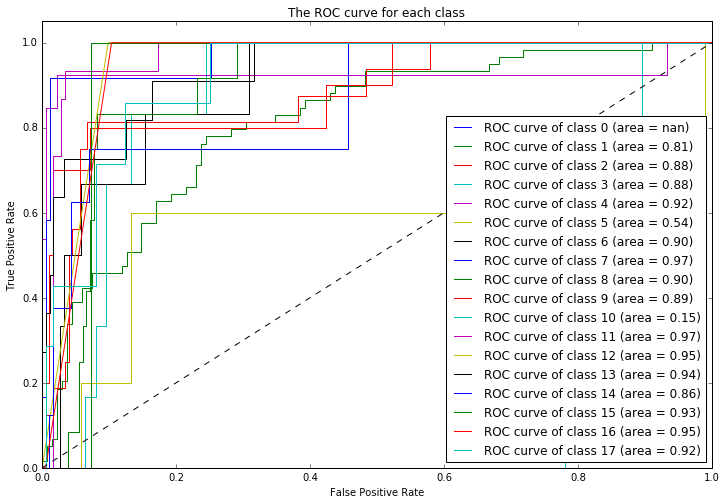

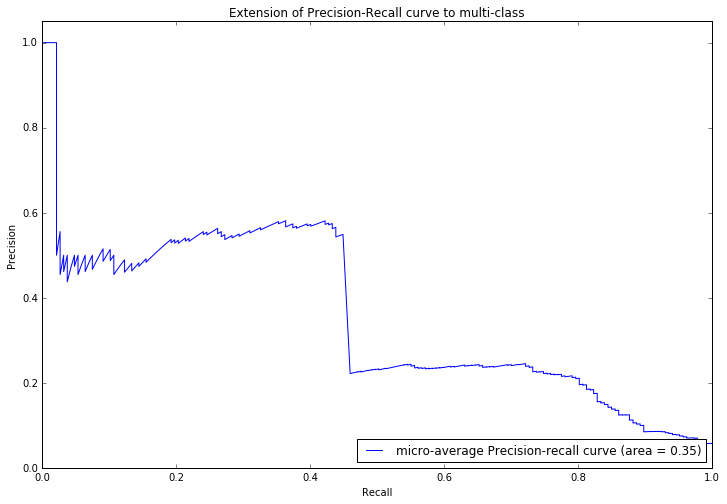

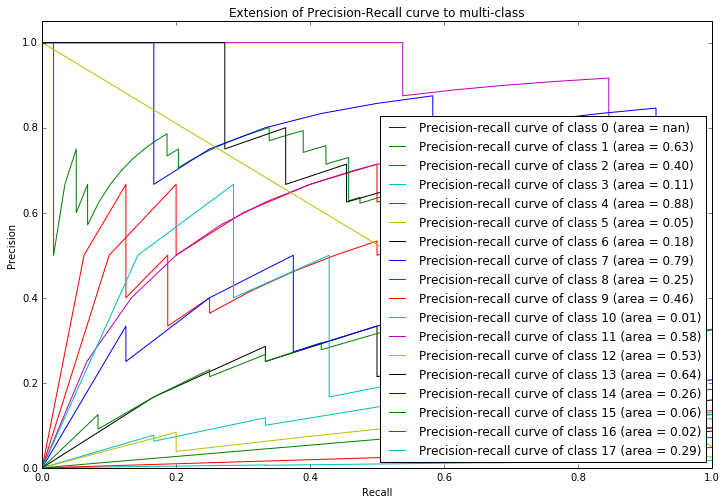

In [18]:
svm_cv_roc(gene.data, gene.Medium)

**Environmental**:

The number of features selected for this variable is  25 



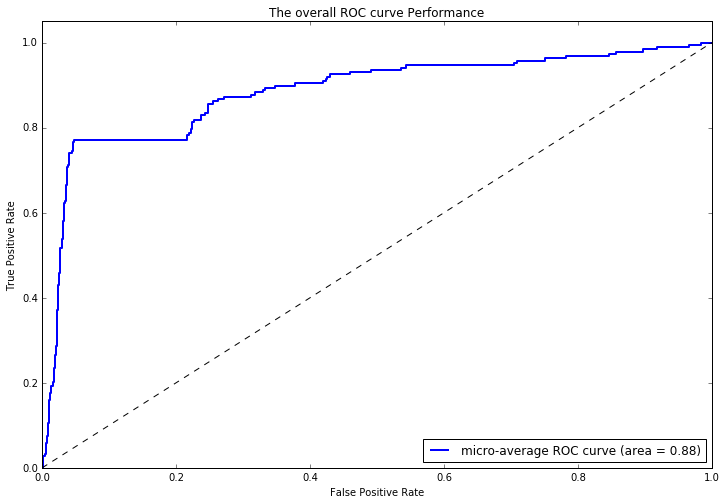

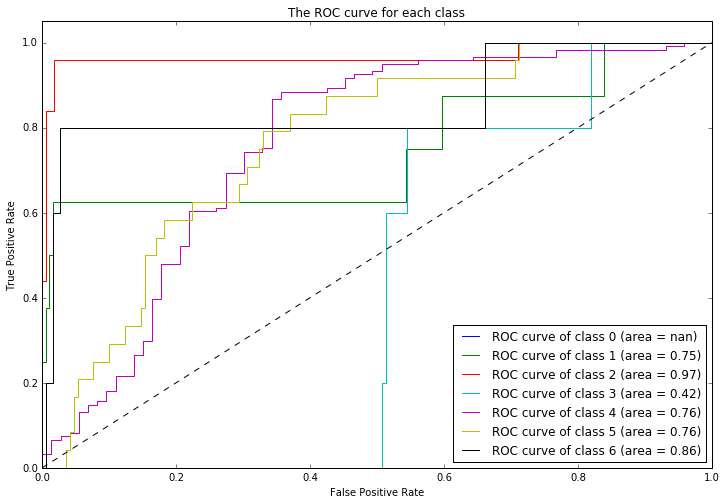

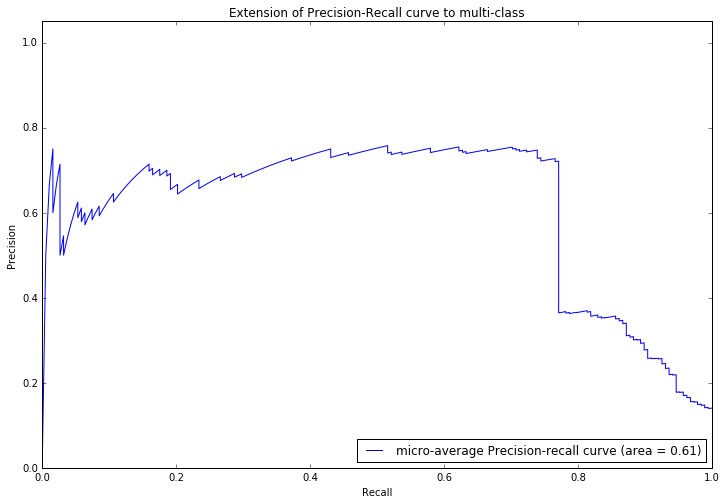

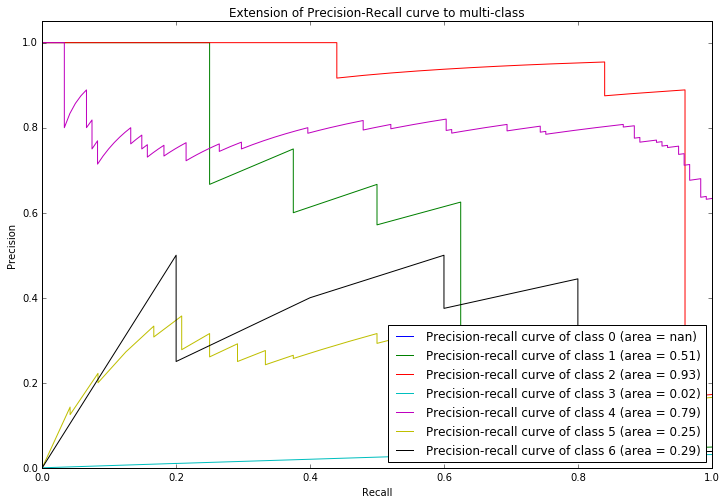

In [19]:
svm_cv_roc(gene.data, gene.Stress)

**Gene Perturbation**:

The number of features selected for this variable is  10 



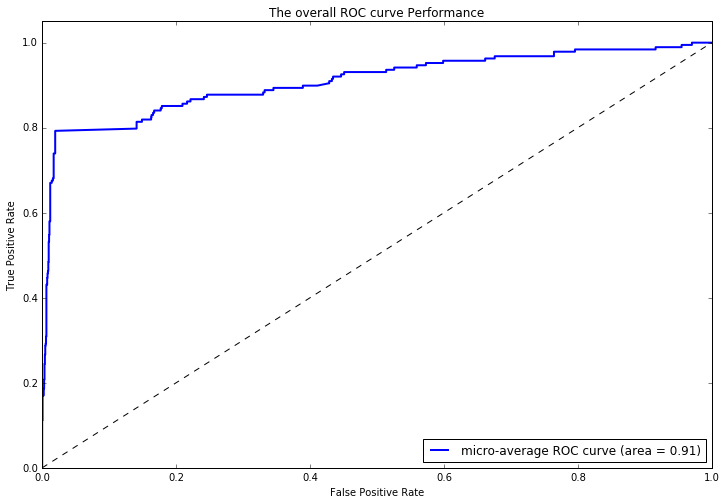

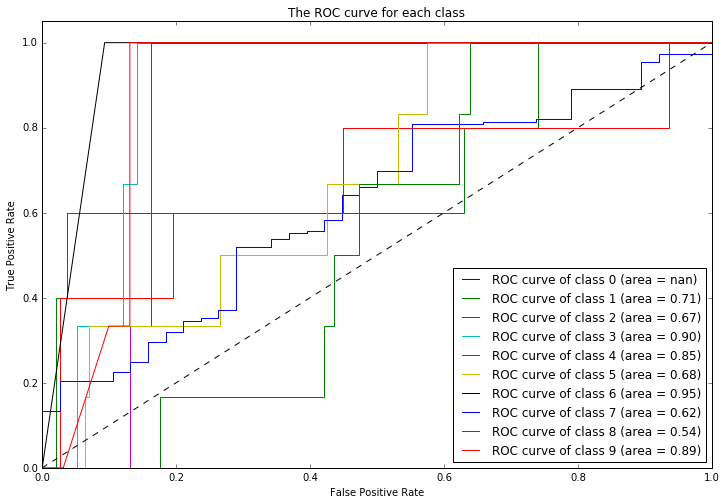

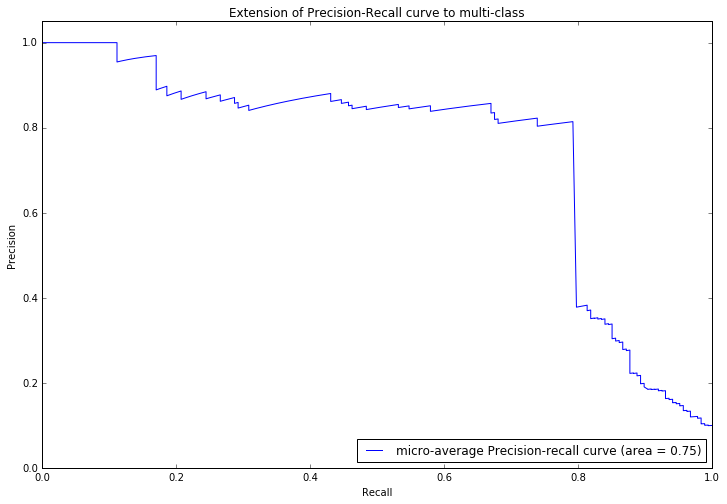

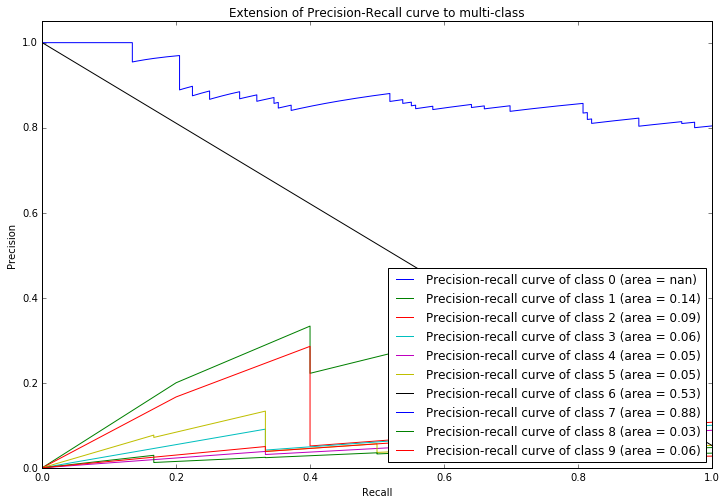

In [20]:
svm_cv_roc(gene.data, gene.GenePerturbed)

## Question 5

Since I have already done the combination of two variables of Medium and Stress in my R script, Now I can do the svm classification:

The number of features selected for this variable is  25 



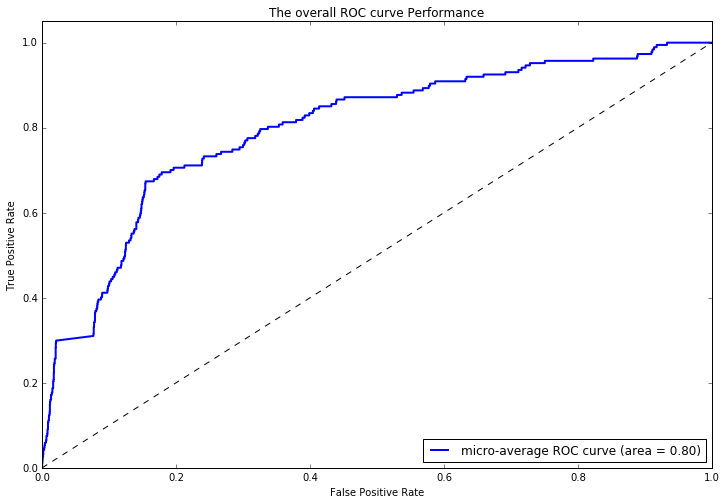

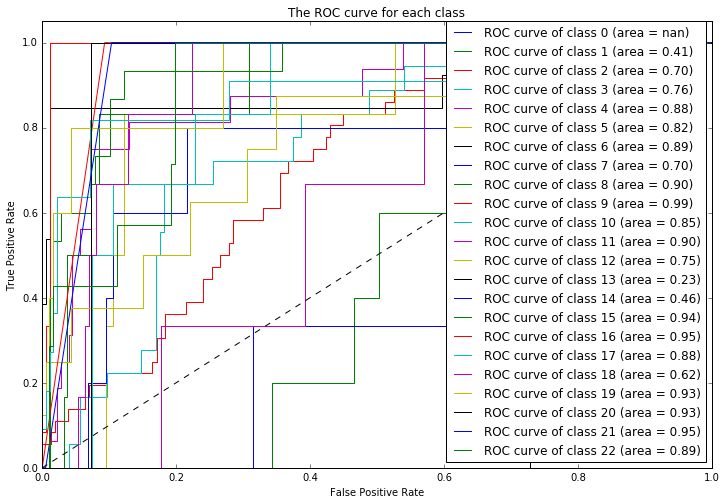

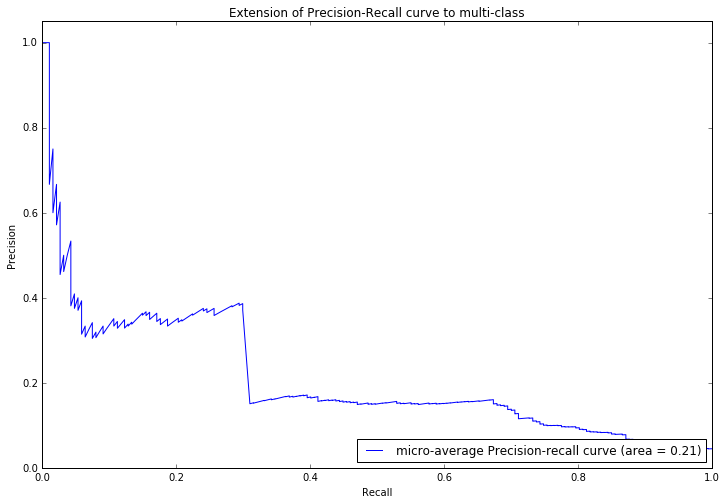

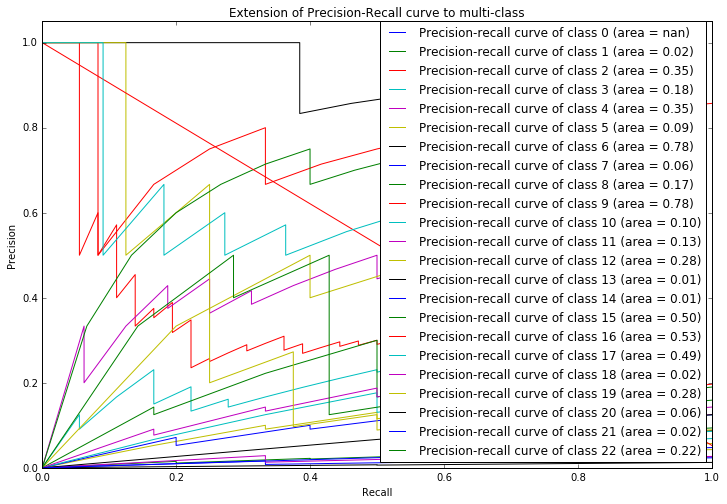

In [21]:
svm_cv_roc(gene.data, gene.Medium_Stress)

The AUC are 0.84 and 0.87 individually, while the combination is 0.79. The AUPRC are 0.32 and 0.62 individually, while the combination is 0.20. These results indicate that this combination prediction is not as good as two individual predictors.

The baseline prediction performance is 0.84 for AUC, and 0.32 for AUPRC.

## Question 6

I will first do PCA

In [22]:
from sklearn.decomposition import PCA

In [23]:
# Normalize data first
gene.data_pca = np.zeros_like(gene.data)
for i in range(gene.data_pca.shape[1]):
    feature = gene.data.iloc[:, i]
    if np.std(feature) == 0:
        gene.data_pca[:, i] = feature
    else:
        gene.data_pca[:, i] = (feature - np.mean(feature)) / np.std(feature)

In [24]:
# Set PCA parameter, the number is 3
gene_pca = PCA(n_components = 3)
gene_pca_fit = gene_pca.fit_transform(gene.data_pca)

The number of features selected for this variable is  3 



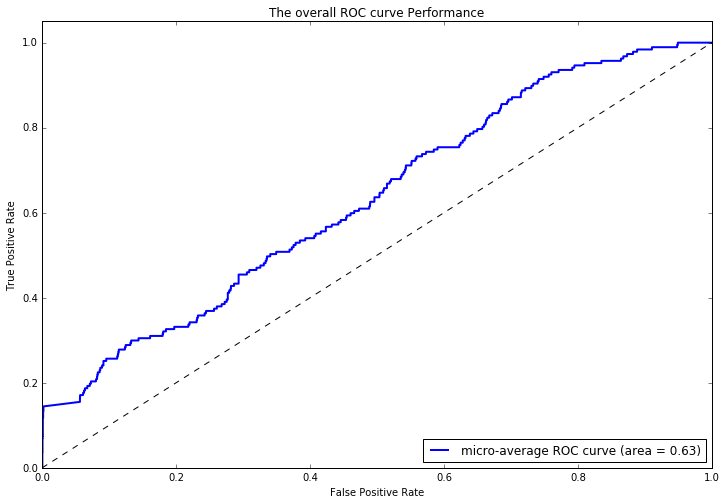

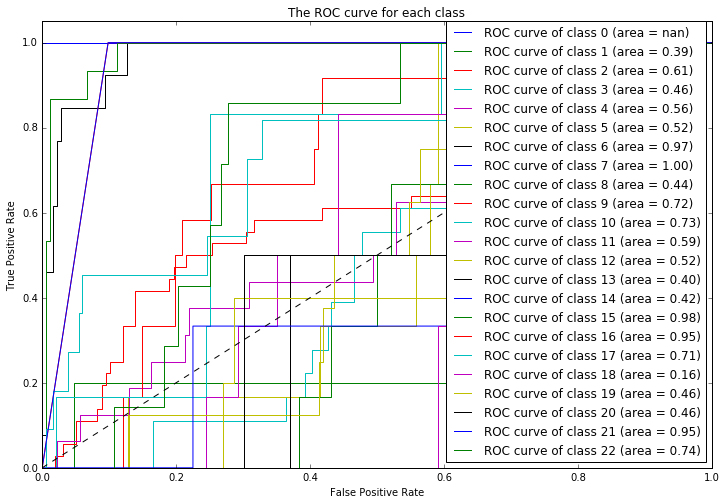

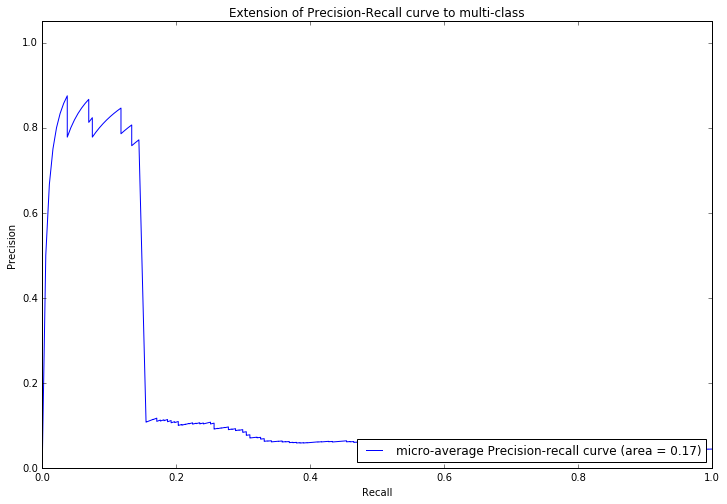

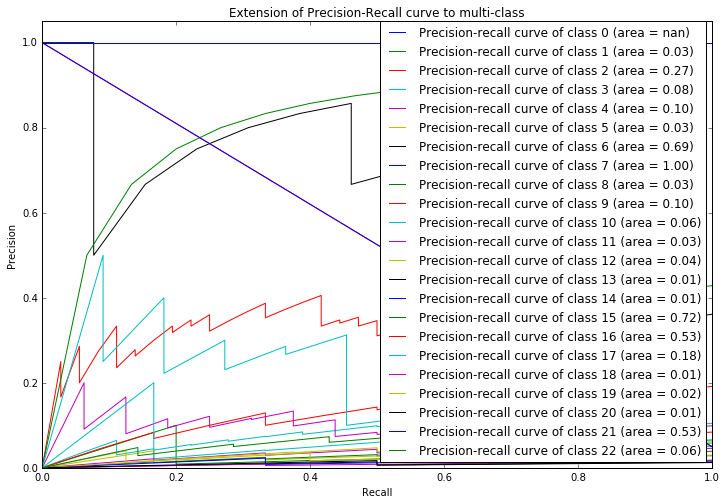

In [25]:
svm_cv_roc(gene_pca_fit, gene.Medium_Stress)

Compared with the results in Question 5, the AUC has been reduced from 0.79 to 0.63, and AUPRC decreases from 0.20 to 0.15, which means PCA preserves about 75% to 80% of the original information.